In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torch.functional as F

In [40]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']#data
words = ' '.join(sentences)
words = list(set(words.split()))
word2id = {w:i for i,w in enumerate(words)}
id2word = {i:w for i,w in enumerate(words)}

n_class = len(words)
n_step = 5
n_hidden = 128

In [41]:
def get_batch(sentences):
    input_batch = [np.eye(n_class)[[word2id[w] for w in sentences[0].split()]]]#[batch_size,n_step,hidden_size]
    output_batch = [np.eye(n_class)[[word2id[w] for w in sentences[1].split()]]]#[batch_size,n_step,hidden_size]
    target_batch = [[word2id[w] for w in sentences[2].split()]]
    return Variable(torch.Tensor(input_batch)),Variable(torch.Tensor(output_batch)),Variable(torch.Tensor(target_batch).type(torch.LongTensor))

In [42]:
class Seq2seq_att(nn.Module):
    def __init__(self):
        super(Seq2seq_att,self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class,hidden_size=n_hidden,dropout=0.5)#[n_step,batch_size,emb_size]
        self.dec_cell = nn.RNN(input_size=n_class,hidden_size=n_hidden,dropout=0.5)#[n_step,batch_size,emb_size]
        self.attn = nn.Linear(n_hidden,n_hidden)
        self.out = nn.Linear(n_hidden*2,n_class)
        
    def get_att_weight(self,enc_output,dec_output):#[n_step,batch_size,emb_size] [1,batch_size,emb_size]
        n_step = len(enc_output)
        att_scores = Variable(torch.zeros(n_step))
        for i in range(n_step):
            att_scores[i] = self.get_att_score(enc_output[i],dec_output)
        return F.softmax(att_scores).view(1,1,-1)
        
    def get_att_score(self,enc_output,dec_output):
        score = self.attn(enc_output)
        return torch.dot(score.view(-1),dec_output.view(-1))
    
    def forward(self,enc_input,enc_hidden,dec_input):
        enc_input = enc_input.transpose(0,1)#[n_step,batch_size,hidden_size]
        #print(enc_input.size())
        dec_input = dec_input.transpose(0,1)
        #print(dec_input.size())
        enc_output,hidden = self.enc_cell(enc_input,enc_hidden)
        train_att = []
        hidden = enc_hidden
        n_step = len(dec_input)
        model = Variable(torch.empty(n_step,1,n_class))
        for i in range(n_step):
            dec_output,hidden = self.dec_cell(dec_input[i].unsqueeze(0),hidden)#[1,batch_size,emb_size]
            attn_weight = self.get_att_weight(enc_output,dec_output)
            train_att.append(attn_weight.squeeze().data.numpy())
            
            context = torch.matmul(attn_weight,enc_output.transpose(0,1))
            dec_output = dec_output.squeeze(0)
            context = context.squeeze(1)
            #print(torch.cat((dec_output, context), 1).size())
            model[i] = self.out(torch.cat((dec_output, context), 1))
        return model.transpose(0, 1).squeeze(0), train_att

/Users/caijie/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/Users/caijie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch: 0400 cost = 0.000966
Epoch: 0800 cost = 0.000305
Epoch: 1200 cost = 0.000150
Epoch: 1600 cost = 0.000089
Epoch: 2000 cost = 0.000057
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


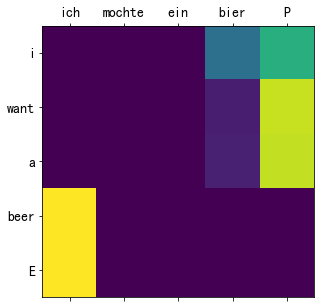

In [46]:
input_batch, output_batch, target_batch = get_batch(sentences)
#print(input_batch.size())#21,16
# hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
hidden = Variable(torch.zeros(1, 1, n_hidden))

model = Seq2seq_att()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(2000):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Test
predict, trained_attn = model(input_batch, hidden, output_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()